# TP de TIFO - Morphologie Mathématique 2

In [59]:
import numpy as np
import skimage
import skimage.morphology
import skimage.io
import matplotlib.pyplot as plt
plt.rcParams['image.cmap'] = 'gray'
import skimage.data
from skimage.color import rgb2gray

# Morphologie et segmentation
Nous allons voir comment segmenter des objets dans des images à l'aide de la morphologie mathématique.

## Premier cas : reprenons les grains de riz
Le but ici est de segmenter les grains de riz individuellement et de les compter

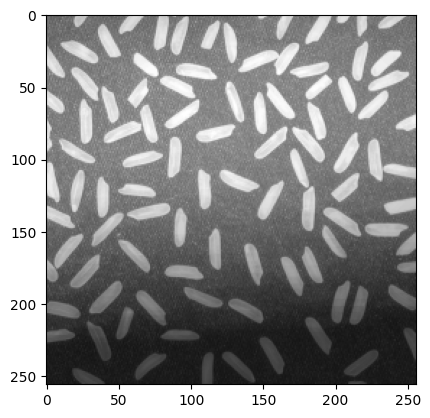

In [60]:
img_riz = skimage.io.imread("riz.png")
plt.imshow(img_riz, vmin=0, vmax=255)

Sans "tricher", refaites la segmentation des grains de riz (c'est pour voir si vous avez retenu ce que vous avez fait au TP 1)

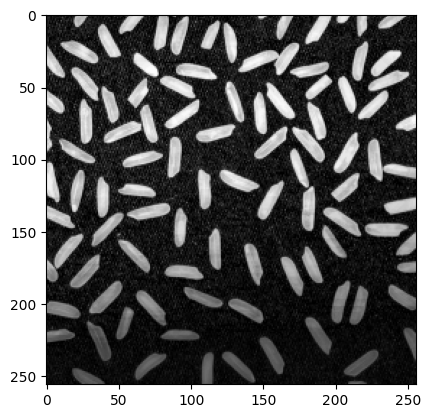

In [61]:
final_riz = img_riz - skimage.morphology.opening(img_riz, skimage.morphology.disk(10))
plt.imshow(final_riz)

In [62]:
mon_seuil = 37

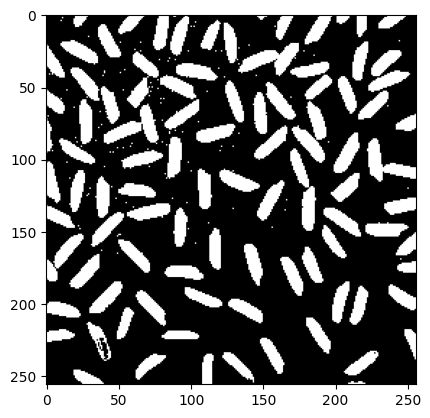

In [83]:
final_im = final_riz > 37
plt.imshow(final_im)

Une fois que vous avez votre image en binaire, retirez les grains qui touchent le bord. 
(Pour enlever ce qui touche le bord, on crée un marqueur de 1 pixel (bord de l'image), on le soustrait à l'image binaire (donc on récupère les marqueurs des objets qui touchent le bord), on reconstruit, et on re-soustrait ! Facile...ou pas !)

In [139]:
final_im

array([[ True, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

Je prefère prendre comme marker : final_im[i,j] quand je touche les bords et mettre 0 sinon puis ensuite faire la reconstruction.

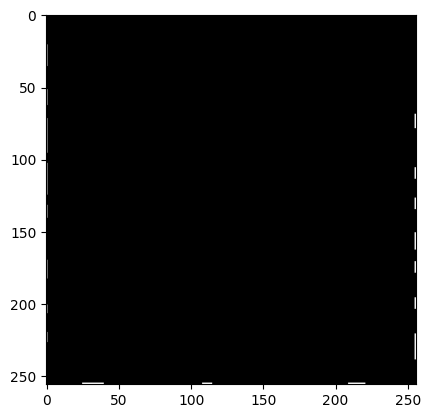

In [140]:


# Créer un marqueur pour les bords de l'image
marker = np.zeros(final_im.shape)
marker[0, :] = final_im[0, :]
marker[-1, :] = final_im[-1, :]
marker[:, 0] = final_im[:, 0]
marker[:, -1] = final_im[:, -1]

plt.imshow(marker)


In [141]:
marker.min(), final_im.min()

(0.0, False)

In [142]:
marker.max(), final_im.max()

(1.0, True)

In [143]:
np.any(marker > final_im)

False

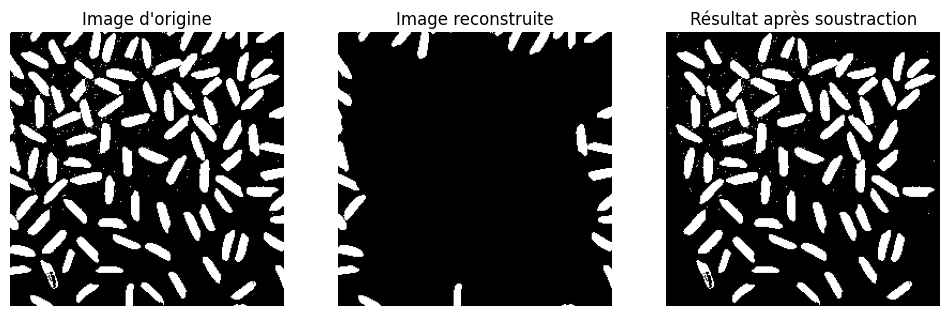

In [144]:
# on cherche les objets à retirer
reconstructed_image = skimage.morphology.reconstruction(marker, final_im)

# on retire les objets touchant le bord
result_image = final_im - reconstructed_image


plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(final_im, cmap='gray')
plt.title('Image d\'origine')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(reconstructed_image, cmap='gray')
plt.title('Image reconstruite')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(result_image, cmap='gray')
plt.title('Résultat après soustraction')
plt.axis('off')

plt.show()

Maintenant il ne reste plus qu'à compter les grains de riz...
Indice, "labeliser" signifie attribuer à chaque composante connexe une valeur unique et croissante, en commençant par 1.

In [147]:
from skimage.measure import label

labeled_image = label(result_image)

labeled_image


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [150]:
num_rice_grains = np.max(labeled_image)

print("Nombre de grains de riz:", num_rice_grains)

Nombre de grains de riz: 170


## Deuxième cas : les cellules musculaires
Ici, le but est de segmenter les cellules...facile non ? 
Je vous demande d'utiliser un watershed pour cette image...

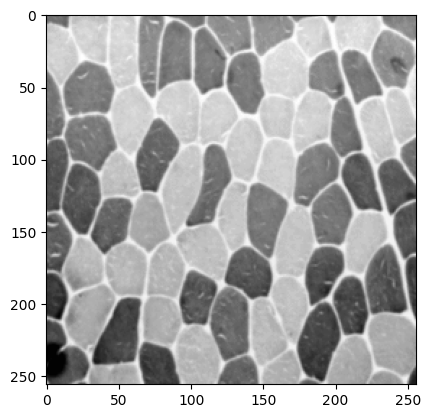

In [166]:
img_muscle = skimage.io.imread("muscle.pgm")
plt.imshow(img_muscle, vmin=0, vmax=255)

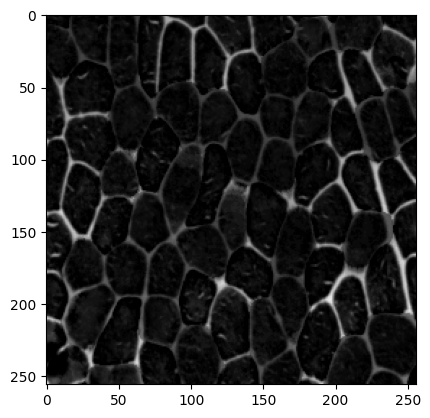

In [167]:
img_muscle = img_muscle - skimage.morphology.opening(img_muscle, skimage.morphology.disk(10))
plt.imshow(img_muscle)

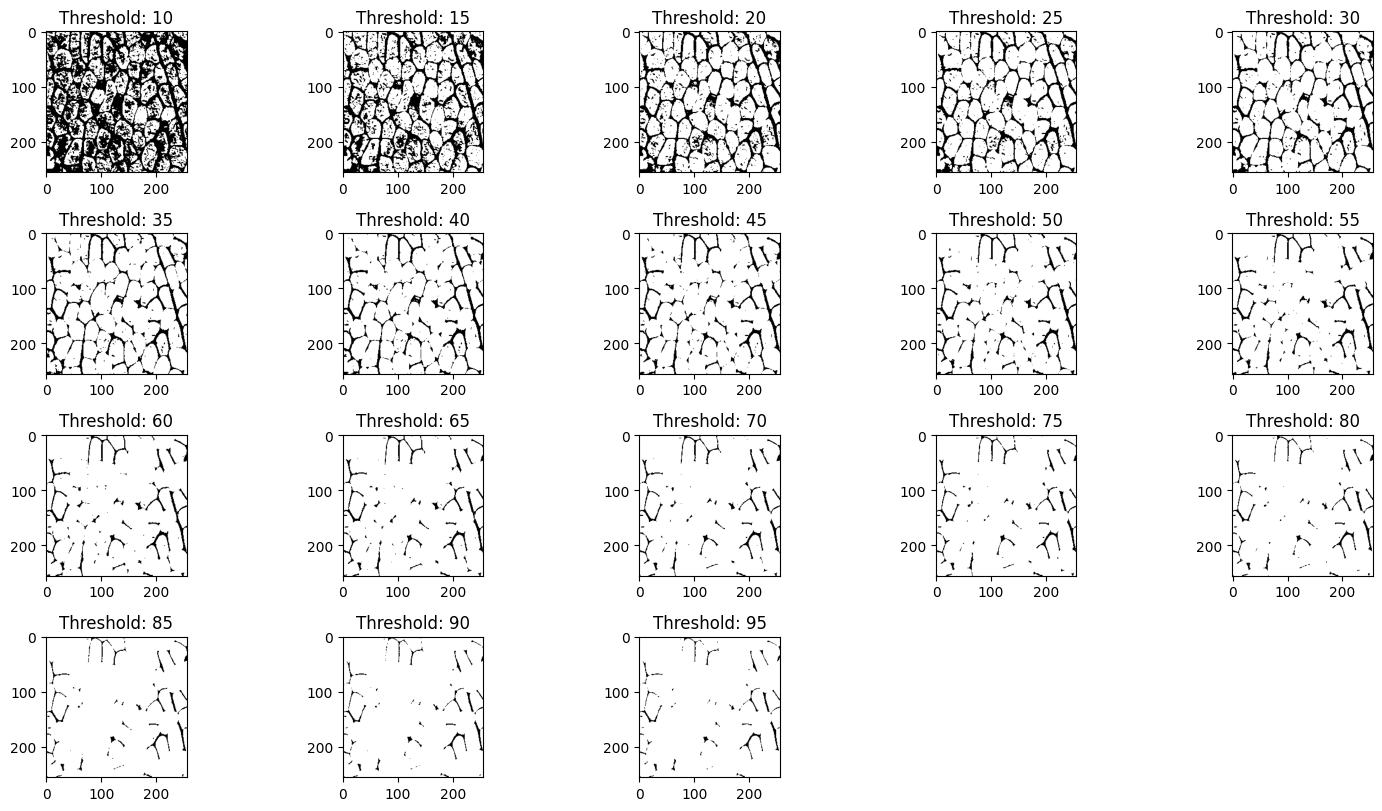

In [168]:
def show_seuil_inf(img_riz, range_inf, range_sup):
    # Définir la taille de la figure
    plt.figure(figsize=(15, 10))
    
    # Boucle sur différentes valeurs de seuil
    for i, threshold in enumerate(range(range_inf, range_sup, 5), 1):
        plt.subplot(5, 5, i)  
        plt.imshow(img_riz < threshold, cmap='gray')  
        plt.title(f"Threshold: {threshold}")
    
    plt.tight_layout() 
    plt.show() 
show_seuil_inf(img_muscle, 10, 100)

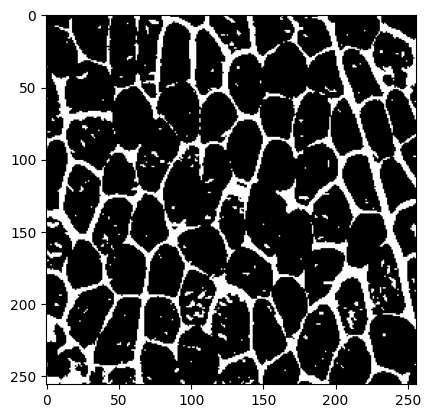

In [169]:
img_muscle = img_muscle > 25
plt.imshow(img_muscle)

In [170]:
from skimage.segmentation import watershed
from scipy import ndimage as ndi
from skimage.feature import peak_local_max

# Appliquer une transformée de distance pour obtenir les pics des cellules
distance = ndi.distance_transform_edt(img_muscle)
coords = peak_local_max(distance, footprint=np.ones((3, 3)), labels=img_muscle)

mask = np.zeros(distance.shape, dtype=bool)
mask[tuple(coords.T)] = True
markers, _ = ndi.label(mask)
labels = watershed(-distance, markers, mask=img_muscle)

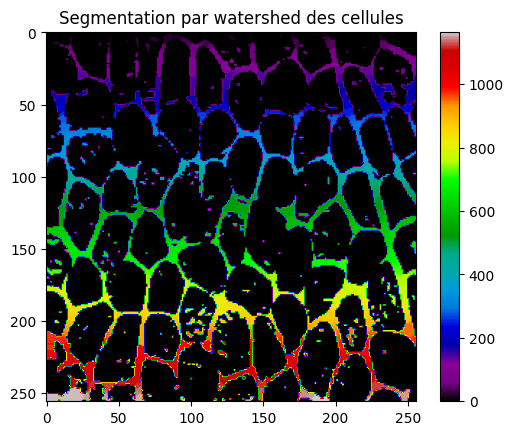

In [171]:
plt.imshow(labels, cmap='nipy_spectral')
plt.colorbar()
plt.title('Segmentation par watershed des cellules')
plt.show()

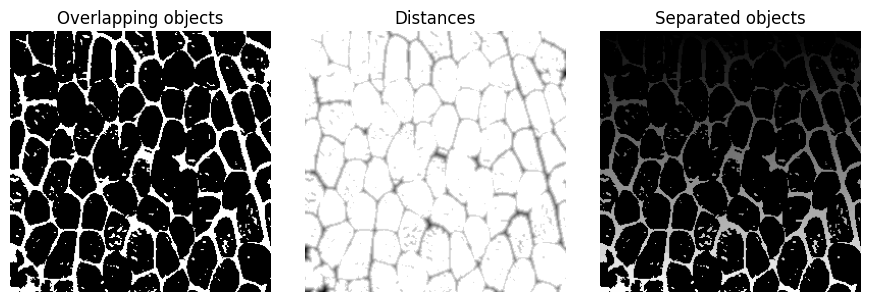

In [172]:
fig, axes = plt.subplots(ncols=3, figsize=(9, 3), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(img_muscle, cmap=plt.cm.gray)
ax[0].set_title('Overlapping objects')
ax[1].imshow(-distance, cmap=plt.cm.gray)
ax[1].set_title('Distances')
ax[2].imshow(labels, cmap=plt.cm.gray)
ax[2].set_title('Separated objects')

for a in ax:
    a.set_axis_off()

fig.tight_layout()
plt.show()

## Troisième cas : les globules rouges
Dans le même esprit, on reprend les globules rouges. La différence : je veux le contour des globules individuels.
Il vous faudra donc :
- combler les trous
- séparer les cellules à l'aide d'un Watershed
- enlever celles qui touchent le bord
- les détourer
- propos

(pas forcément dans cet ordre d'ailleurs)

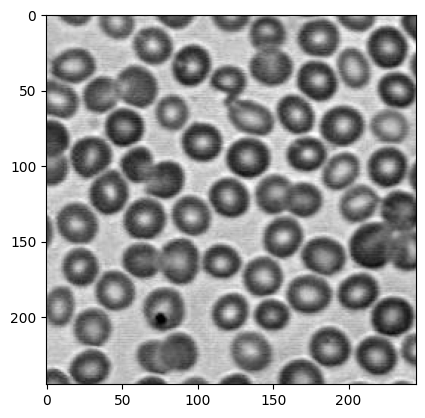

In [193]:
img_glob = skimage.io.imread("bloodcells.pgm")
plt.imshow(img_glob, vmin=0, vmax=255)

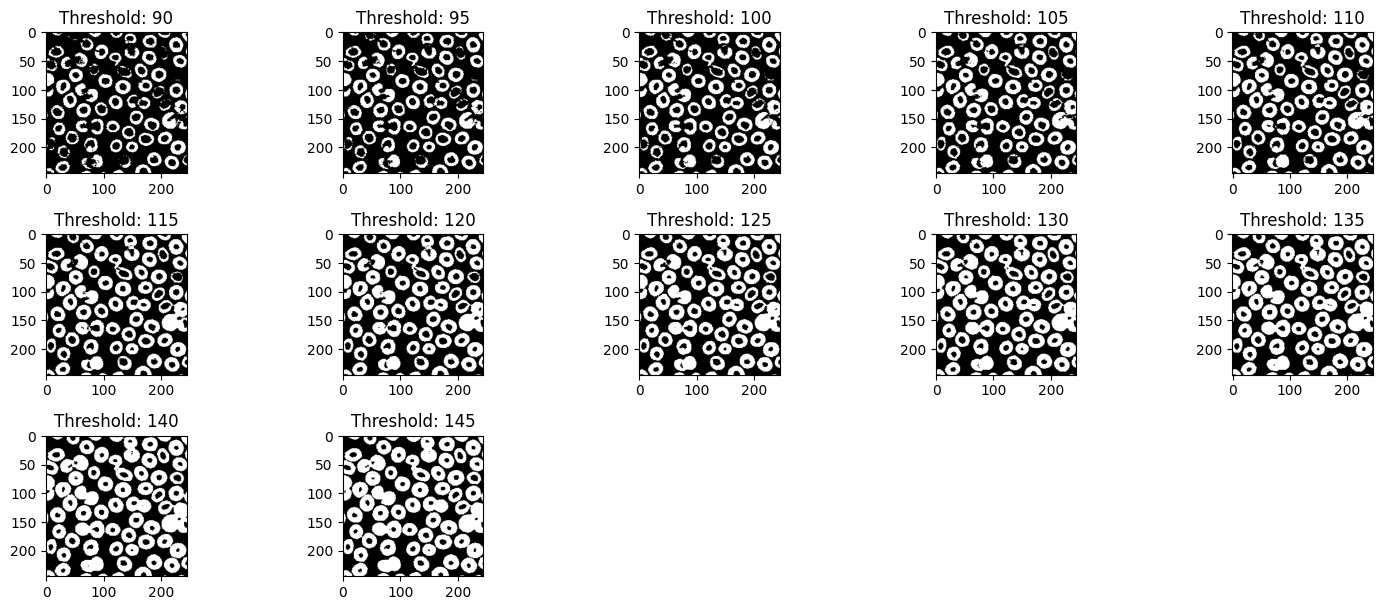

In [194]:
show_seuil_inf(img_glob, 90, 150)

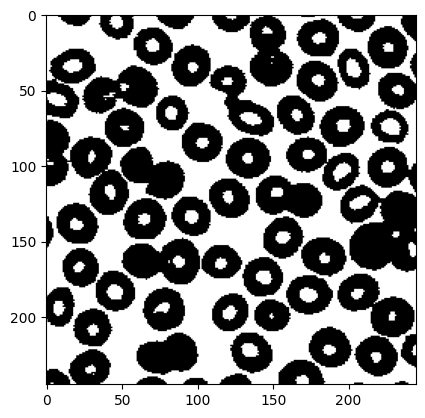

In [195]:
img_glob = img_glob > 145
plt.imshow(img_glob)

In [199]:
# Appliquer une transformée de distance pour obtenir les pics des cellules
distance = ndi.distance_transform_edt(img_glob)
coords = peak_local_max(distance, footprint=np.ones((3, 3)), labels=img_glob)

mask = np.zeros(distance.shape, dtype=bool)
mask[tuple(coords.T)] = True
markers, _ = ndi.label(mask)
labels = watershed(-distance, markers, mask=img_glob)

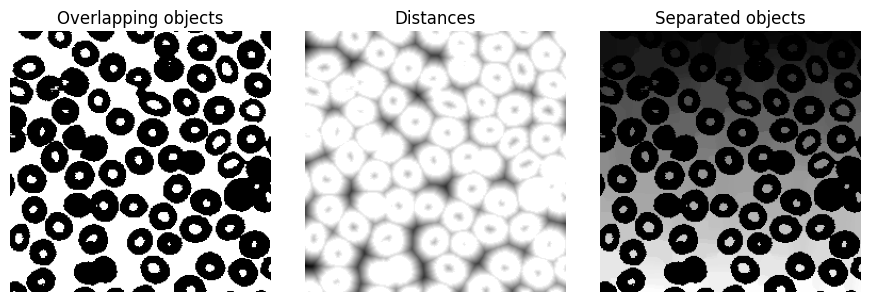

In [201]:
fig, axes = plt.subplots(ncols=3, figsize=(9, 3), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(img_glob, cmap=plt.cm.gray)
ax[0].set_title('Overlapping objects')
ax[1].imshow(-distance, cmap=plt.cm.gray)
ax[1].set_title('Distances')
ax[2].imshow(labels, cmap=plt.cm.gray)
ax[2].set_title('Separated objects')

for a in ax:
    a.set_axis_off()

fig.tight_layout()
plt.show()

In [202]:
# Créer un marqueur pour les bords de l'image
marker = np.zeros(labels.shape)
marker[0, :] = labels[0, :]
marker[-1, :] = labels[-1, :]
marker[:, 0] = labels[:, 0]
marker[:, -1] = labels[:, -1]


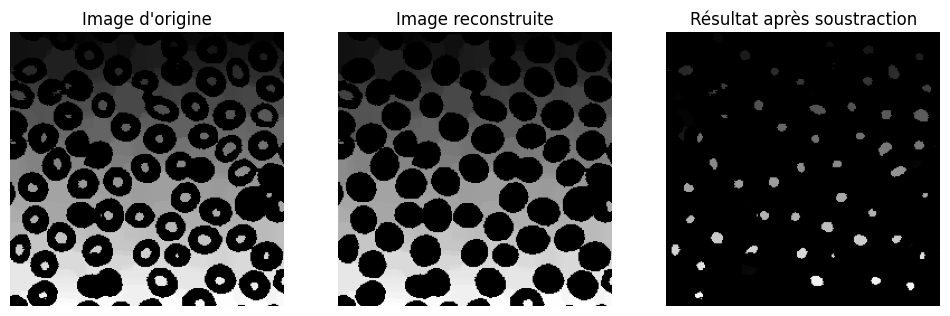

In [203]:
# on cherche les objets à retirer
reconstructed_image = skimage.morphology.reconstruction(marker, labels)

# on retire les objets touchant le bord
result_image = labels - reconstructed_image


plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(labels, cmap='gray')
plt.title('Image d\'origine')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(reconstructed_image, cmap='gray')
plt.title('Image reconstruite')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(result_image, cmap='gray')
plt.title('Résultat après soustraction')
plt.axis('off')

plt.show()

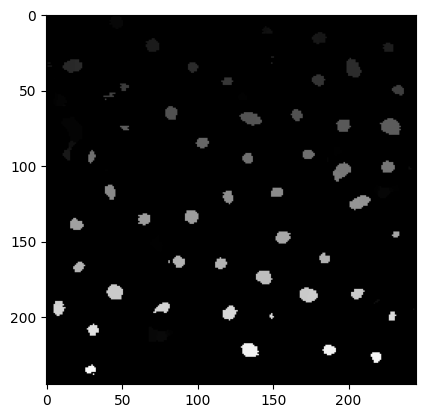

In [204]:
plt.imshow(result_image)

## Bonus 1
Sur l'image suivante, récupérez les coronavirus (les boules bleues) !

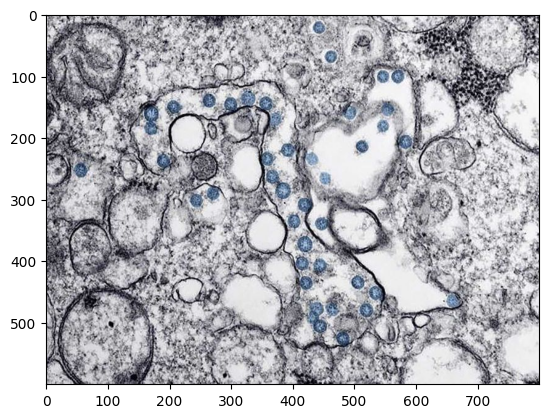

In [254]:
covid = skimage.io.imread("covid.jpeg")
plt.imshow(covid)

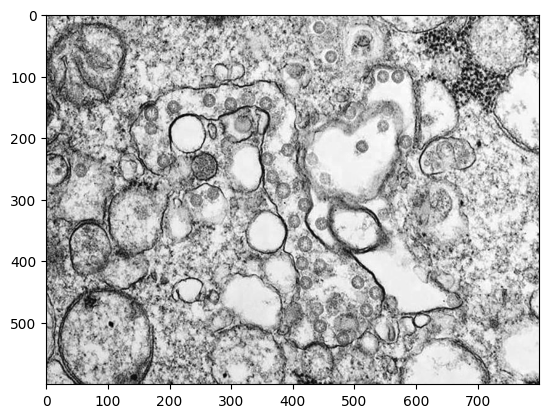

In [255]:
blue_channel = covid[:, :, 2]
plt.imshow(blue_channel)

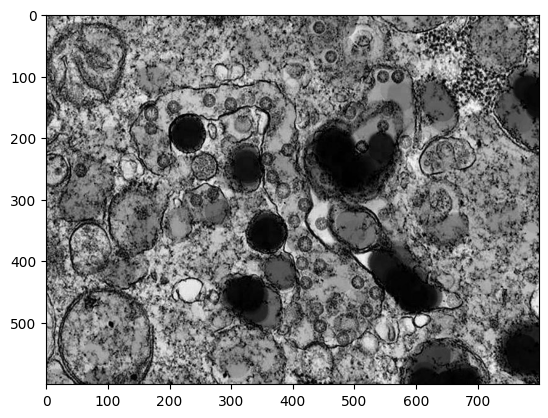

In [256]:
blue_channel = blue_channel - skimage.morphology.opening(blue_channel, skimage.morphology.disk(20))
plt.imshow(blue_channel)

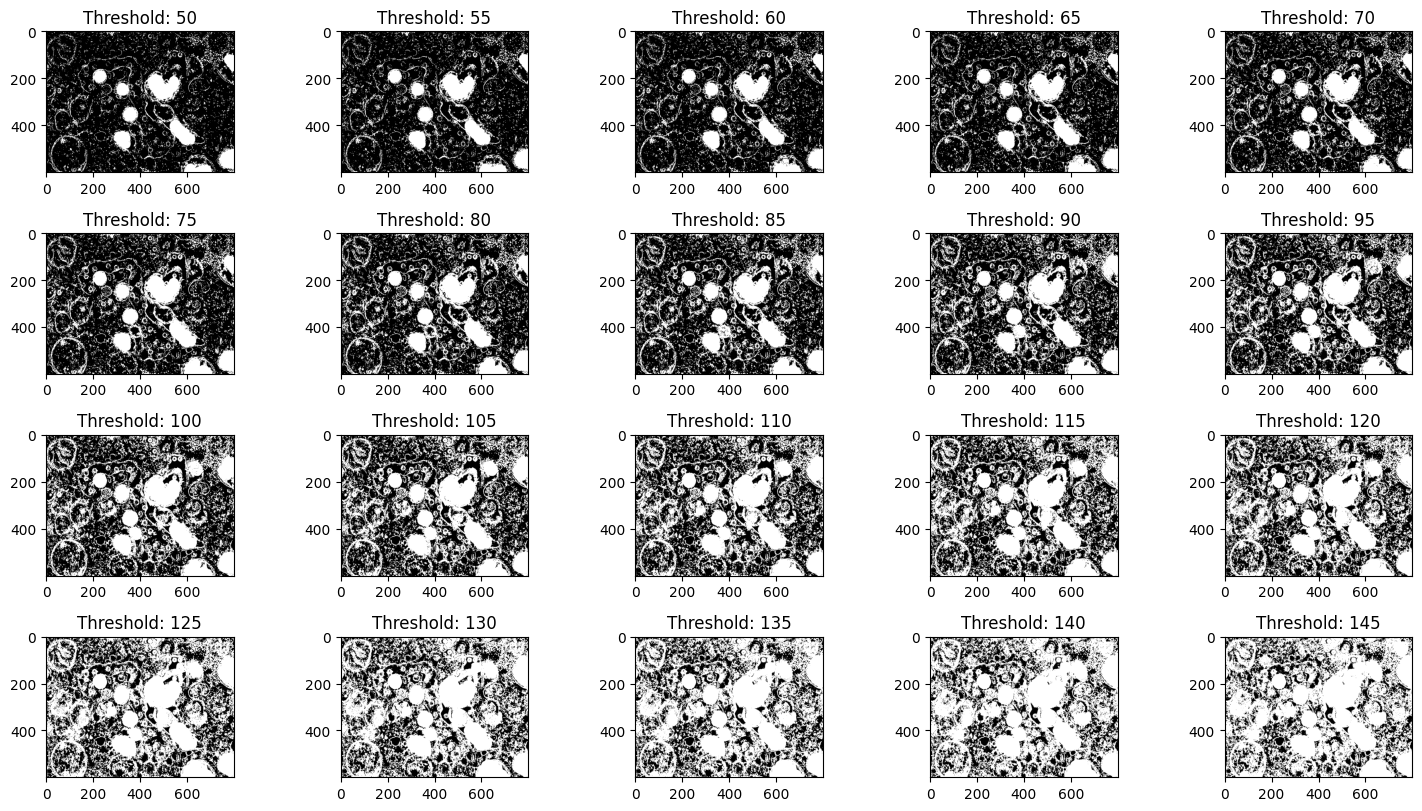

In [261]:
show_seuil_inf(blue_channel, 50, 150)

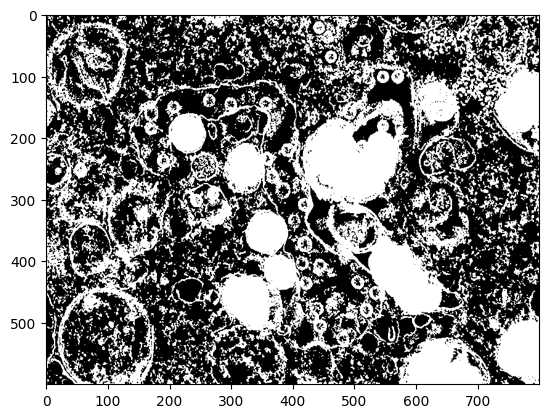

In [262]:
bin_covid = blue_channel < 100
plt.imshow(bin_covid)

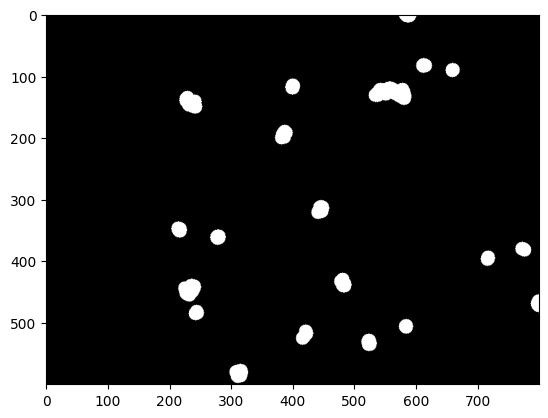

In [267]:
im_disk = skimage.morphology.closing(bin_covid, skimage.morphology.disk(11))
plt.imshow(255 - im_disk)

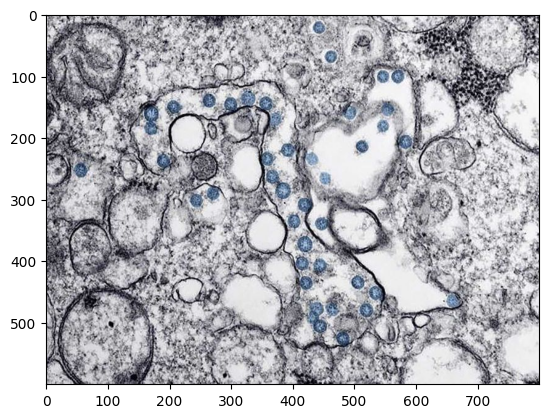

In [265]:
plt.imshow(covid)